In [1]:
# baseball-regression.ipynb
# Alexis Perumal, Venkat Pinnika, Young You, 1/8/2020
#
# Objective:
# . Build a predictor for the winner of baseball games (visitor or home)
#   with > 50% prediction accuracy, with statistical accuracy.
# . Analysis will be done by season, looking at all the regular season
#   games of a given year with each days' game predicted based on info
#   up to, but not including that day.
#
# Strategy:
# . Build a dataframe of games (rows) and factors to build a regression
#   model for visiting net points, and by extension, predict the winner
#   of each game (visitor or home).
# . Explore candidate factors with regression analysis (T-stat, F-stat,
#   p-value), build and optimize a simple LSR model using a training set
#   through the 2017 Season.
# . Plot the results.
# . Ultimately, apply the model to the 2018, then 2019 seasons.

In [10]:
# Modules
import os
import csv
import pprint
import pandas as pd
import glob
import pprint
import datetime
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
!pwd

/Users/aperumal/OneDrive/Personal/UCSD_Data_Science_Bootcamp/Homework/2019-12-18_Proj1_Baseball-Predictor/baseball-predictor/alexis-regression


In [11]:
# Support functions
def date_str(date: int):
    s = str(date)
    return f"{s[0:4]}-{s[4:6]}-{s[6:]}"


# Passed the gamedays series (YYYYMMDD) and season (year) return with the first
# and last game dates.
def date_range(gamedays, season):
    # Converts 'YYYY' string to an integer start date, YYYY0101 and end date YYYY1231
    def season_to_date(season): 
#         return (int(season)*10000 + 101, int(season)*10000+1231)
        # Hack to shorten the season for dev purposes (faster analysis)
        return (int(season)*10000 + 101, int(season)*10000+430)
    
    first_of_year, last_of_year = season_to_date(season)
    season_gamedays = gamedays.loc[((gamedays >= first_of_year) &
                                    (gamedays <= last_of_year))]
    return (season_gamedays.iloc[0], season_gamedays.iloc[-1])
    

# returns new game date offset by n. Passed in the gamedays series.
def gamedays_offset(gamedays, base_date, n): 
    if base_date not in gamedays.values:
        raise ValueError(f"{base_date}, not in the the gamedays series.")
    base_date_index = gamedays[gamedays==base_date].index[0]
    if ((n + base_date_index) < 0) or n + base_date_index >= len(gamedays):
        raise ValueError(f"Attempting to calculate a game date outside the dataset.")
        return(0)  # Out of range
    else:
        new_index = base_date_index + n
        return gamedays.iloc[new_index]
    
def derive_metrics(results_df):
    num_games = len(results_df)
    num_correct = results_df['Prediction Correct?'].values.sum()
    percent_correct = num_correct/num_games*100.
    return (num_games, num_correct, percent_correct)

In [12]:
def read_source_data():
    def reader(f):
        df = pd.read_csv(f, index_col=False, header=None)  
        df.columns = [("Col_"+str(i)) for i in range(1,df.shape[1]+1)]       
        return df

    files = glob.glob("../datasets/Final_Data_Files/GL*.csv")
    files.sort()
    df = pd.concat([reader(f) for f in files])
    old_df_len = len(df)
    
    # Insert column headers
    df = df.rename(columns={'Col_1':'Date',
                            'Col_4':'Visiting Team',
                            'Col_5':'Visiting League',
                            'Col_7':'Home Team',
                            'Col_8':'Home League',
                            'Col_10':'Visiting Score',
                            'Col_11':'Home Score',
                            'Col_102':'V Start Pitcher ID',
                            'Col_104':'H Start Pitcher ID'
                           }).reset_index()
    df = df[['Date', 'Visiting Team', 'Visiting League', 'Home Team', 'Home League',
            'Visiting Score','Home Score', 'V Start Pitcher ID','H Start Pitcher ID']]
    
    df = df.replace('FLO','MIA') # After the 2011 season, the Florida Marlins
                                 # rebranded themselves the Miami Marlins. This
                                 # search and replace makes the two the same.
    
    # Drop all rows with missing information
    # print(df.head())
    df = df.dropna(how='any')
    if len(df) < old_df_len:
        print(f"Dropped {old_df_len-len(df)} rows due to missing data.")
    
    # Create new columns we'll need. 
#     df['Key'] = df['Date'].astype(str) + df['Visiting Team']
    df['Home Winner'] = df['Home Score'] > df['Visiting Score']
    df['V NetRuns'] = df['Visiting Score'] - df['Home Score']
    df['H NetRuns'] = - df['V NetRuns']
    
    #     print(df.shape)
    print(f"Dataset loaded with {df.shape[0]} games, ", end='')
    print(f"{df.shape[1]} columns, {date_str(df.iloc[0, 0])} - ", end='')
    print(f"{date_str(df.iloc[-1,0])}")
    return df

# read_source_data()

In [27]:
def net_point_predictor(outcomes_df, lookback_n, prior_exclude=0, net=True):
    # Let's get started. Read the dataset.
    games_df = read_source_data()
    
    # Caculate seasons represented in the dataset
    seasons = games_df['Date'].transform(lambda x: int(x/10000)).unique().tolist()
    pprint.pprint(seasons)
    

    # Calculate rolling average of net points excluding the current row (shift=prior_exclude+1)
    if net:
        games_df = games_df.sort_values(by = ['Visiting Team','Date'])
        games_df['V NP Avg'] = games_df.groupby('Visiting Team')['V NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())

        games_df = games_df.sort_values(by = ['Home Team','Date'])
        games_df['H NP Avg'] = games_df.groupby('Home Team')['H NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
    else:
        games_df = games_df.sort_values(by = ['Visiting Team','Date'])
        games_df['V NP Avg'] = games_df.groupby('Visiting Team')['Visiting Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())

        games_df = games_df.sort_values(by = ['Home Team','Date'])
        games_df['H NP Avg'] = games_df.groupby('Home Team')['Home Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
       
        
        
    games_df = games_df.sort_index()

    print(f"  # of games before dropping lookback window: {len(games_df)}")
    games_df.to_csv("output/result_before_dropna.csv")
    games_df = games_df.dropna(how='any')
    print(f"  # of games after dropping lookback window: {len(games_df)}")

    games_df['Home Wins?'] = games_df['H NP Avg'] >= games_df['V NP Avg']
    games_df['Prediction Correct?'] = games_df['Home Wins?'] == games_df['Home Winner']

    num_games = len(games_df)
    num_correct = games_df['Prediction Correct?'].values.sum()
    percent_correct = num_correct/num_games*100.
    
    new_row = pd.Series({'Season':0,
                   'Lookback':n,
                   'Net':net,
                   'Num Games':num_games,
                   'Num Correct':num_correct,
                   '% Correct':percent_correct,
                   'Comment':'All Seasons'})
    outcomes_df = outcomes_df.append(new_row, ignore_index=True)
    
    for season in seasons:
        start_date = int(season)*10000 + 101  # YYYYMMDD, Jan 01 of the Year
        end_date = int(season)*10000 + 1231   # YYYYMMDD, DEC 31 of the Year
        season_df = games_df.loc[((games_df['Date']>= start_date) &
                                  (games_df['Date']<= end_date)), :]
        
        num_games = len(season_df)
        num_correct = season_df['Prediction Correct?'].values.sum()
        percent_correct = num_correct/num_games*100.

        new_row = pd.Series({'Season':season,
                       'Lookback':n,
                       'Net':net,
                       'Num Games':num_games,
                       'Num Correct':num_correct,
                       '% Correct':percent_correct,
                       'Comment':''})
        outcomes_df = outcomes_df.append(new_row, ignore_index=True)
          
    return outcomes_df


In [29]:
# Top level (main) code, read in the dataset, add the columns we care about.
outcomes_df = pd.DataFrame(columns=['Season', 'Lookback', 'Net', 'Num Games',
                                  'Num Correct', '% Correct', 'Comment'])


# for n in [1, 2, 5, 10, 15, 20, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500]:
for n in [50, 60, 70, 80, 90, 100]:
# for n in [75]:
    prior_exclude = 0

    net=False
    outcomes_df = net_point_predictor(outcomes_df, n, prior_exclude, net=net)
    print(f"  Net Point Predictor, lookback={n}, prior exclude={prior_exclude}, net={net} done.")
    print("")

outcomes_df


Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 17900
  Net Point Predictor, lookback=50, prior exclude=0, net=False done.

Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 17604
  Net Point Predictor, lookback=60, prior exclude=0, net=False done.

Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 17301
  Net Point Predictor, lookback=70, prior exclude=0, net=False done.

Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  # of ga

/anaconda3/envs/py365_for_class/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in long_scalars


Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 16397
  Net Point Predictor, lookback=100, prior exclude=0, net=False done.



,Season,Lookback,Net,Num Games,Num Correct,% Correct,Comment
0,0,50,False,17900,9383,52.418994,All Seasons
1,2010,50,False,893,488,54.647256,
2,2011,50,False,2429,1288,53.025937,
3,2012,50,False,2430,1242,51.111111,
4,2013,50,False,2431,1309,53.846154,
5,2014,50,False,2430,1254,51.604938,
6,2015,50,False,2429,1262,51.955537,
7,2016,50,False,2428,1294,53.294893,
8,2017,50,False,2430,1246,51.275720,
9,0,60,False,17604,9258,52.590320,All Seasons


In [30]:
season_gb = outcomes_df.groupby('Season')
type(season_gb)
y = season_gb.get_group(0)['% Correct']
print(y)
x = season_gb.get_group(0)['Lookback']
print(x)

0     52.418994
9     52.590320
18    53.060517
27    52.933576
36    52.972876
45    52.771849
Name: % Correct, dtype: float64
0      50
9      60
18     70
27     80
36     90
45    100
Name: Lookback, dtype: object


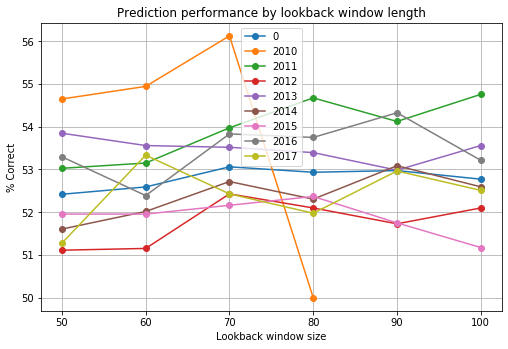

In [31]:
fig = plt.figure(figsize=(8,5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.set_title('Prediction performance by lookback window length')
axes.set_xlabel('Lookback window size')
axes.set_ylabel('% Correct')

# for season in range(2012, 2018):
for season in [0, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]:
    x = season_gb.get_group(season)['Lookback']
    y = season_gb.get_group(season)['% Correct']
    axes.plot(x, y, label=str(season), marker='o')
    
axes.legend()
axes.grid()
plt.show()

In [32]:
if True:
    base_path = str(datetime.datetime.now()).replace(':', '-').replace(' ', '_')
    data_output_path = "output/" + base_path + "_output.csv"
    outcomes_df.to_csv(path_or_buf=data_output_path)
    plot_output_path = "plot/" + base_path + "_plot.png"
    fig.savefig(plot_output_path)

In [22]:
# Regression Analysis
def net_points_regression(lookback_n, prior_exclude=0):
    # Let's get started. Read the dataset.
    games_df = read_source_data()
    
    # Caculate seasons represented in the dataset
    seasons = games_df['Date'].transform(lambda x: int(x/10000)).unique().tolist()
    pprint.pprint(seasons)
    

    # Calculate rolling average of net points excluding the current row (shift=prior_exclude+1)
    games_df = games_df.sort_values(by = ['Visiting Team','Date'])
    games_df['V NP Avg'] = games_df.groupby('Visiting Team')['V NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
    games_df['V P Avg'] = games_df.groupby('Visiting Team')['Visiting Score'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())
    
    games_df = games_df.sort_values(by = ['Home Team','Date'])
    games_df['H NP Avg'] = games_df.groupby('Home Team')['H NetRuns'].transform(lambda x: x.shift(periods=prior_exclude+1).rolling(window = lookback_n).mean())

    games_df = games_df.sort_index()

    print(f"  # of games before dropping lookback window: {len(games_df)}")
    games_df.to_csv("output/result_before_dropna.csv")
    games_df = games_df.dropna(how='any')
    print(f"  # of games after dropping lookback window: {len(games_df)}")

    
    # The data table is built, now let's do the regression
    x = games_df['V NP Avg']
#     y = games_df['V NetRuns']
    y = games_df['V P Avg']
    slope, y_int, r, p, se = stats.linregress(x, y)
    
    print(f"slope: {slope}, int: {y_int}, r: {r}, r2: {r**2}, p: {p}, std error of the mean: {se}")
    
    
    
#     games_df['Pred V NP']
    
    
#     games_df['Home Wins?'] = games_df['H NP Avg'] >= games_df['V NP Avg']
#     games_df['Prediction Correct?'] = games_df['Home Wins?'] == games_df['Home Winner']

    
net_points_regression(80)

Dataset loaded with 19437 games, 12 columns, 2010-04-04 - 2017-10-01
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  # of games before dropping lookback window: 19437
  # of games after dropping lookback window: 17027
slope: 0.47421927420502547, int: 4.28971818363469, r: 0.7092933192219544, r2: 0.5030970126928973, p: 0.0, std error of the mean: 0.0036119819865333665


In [ ]:
# From Venkat, on pitchers
# v_pitchers = game_day_df2['V Start Pitcher ID'].to_list()
# v_pitcher_net_score = []
# for pitcher in v_pitchers:
#     v_pitcher_net_score.append(train_df.loc[(train_df['V Start Pitcher ID']==pitcher),:]['Home Score'].mean())
# game_day_df2['V Avg Pitcher Runs given'] = v_pitcher_net_score
# h_pitchers = game_day_df2['H Start Pitcher ID'].to_list()
# h_pitcher_net_score = []
# for pitcher in h_pitchers:
#     h_pitcher_net_score.append(train_df.loc[(train_df['H Start Pitcher ID']==pitcher),:]['Visiting Score'].mean())
# game_day_df2['H Avg Pitcher Runs given'] = h_pitcher_net_score
# game_day_df2['Predict Home Pitcher Wins?'] = game_day_df2['H Avg Pitcher Runs given'] < game_day_df2['V Avg Pitcher Runs given']
# game_day_df2